## Lectura fitxer

In [1]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)

In [2]:
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)

In [3]:
X = df.drop('target', axis=1)
y = df['target']

## Aplicació model

### Utilització de totes les característiques

Fent 2 agrupacions per determinar si necessiten o no assistència médica

In [4]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X)

In [6]:
df_clustered = X.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,mbi_ex,mbi_cy,mbi_ea,cluster
0,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,17,13,20,1
1,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,14,11,26,0
2,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,24,7,23,0
3,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,16,10,21,0
4,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,22,14,23,0


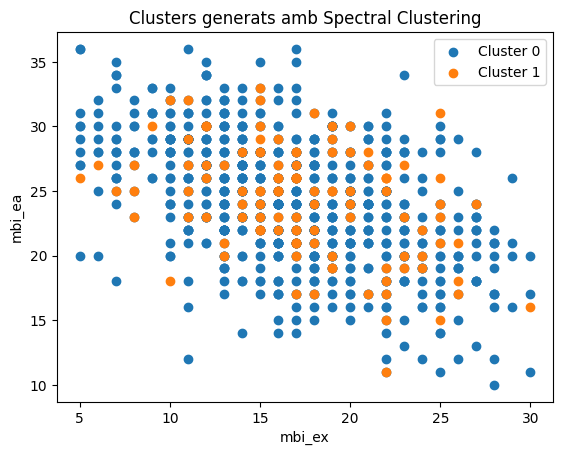

In [7]:
# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points.iloc[:, 14], cluster_points.iloc[:, 16], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

In [8]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

               age      year       sex      glang      part       job  \
cluster                                                                 
0        22.359638  3.169470  1.694696   2.241915  0.573092  0.360931   
1        22.548673  2.646018  1.699115  97.000000  0.495575  0.265487   

            stud_h    health      psyt        jspe   qcae_cog   qcae_aff  \
cluster                                                                    
0        24.936611  3.783959  0.231565  106.712807  58.703752  34.971539   
1        27.699115  3.734513  0.176991  104.061947  57.309735  33.504425   

              amsp  erec_mean     mbi_ex     mbi_cy     mbi_ea  
cluster                                                         
0        23.241915   0.723064  16.813713  10.024580  24.209573  
1        22.522124   0.700169  17.318584  10.451327  24.194690  


In [9]:
# Getting the number of patients in each cluster
cluster_grouped.size()

cluster
0    773
1    113
dtype: int64

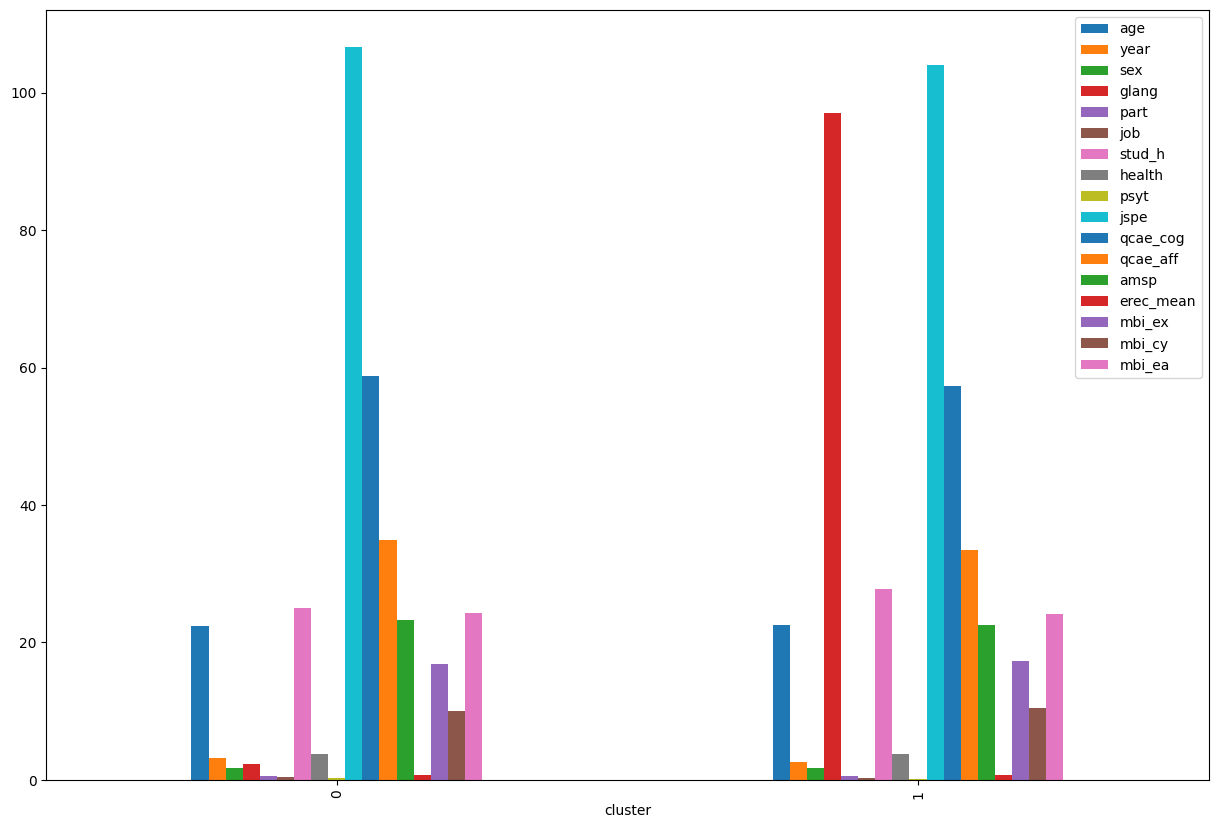

In [10]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

Com podem observar als resultats dels valors mitjans i de la gràfica, no podem concloure cap conclusió clara. Veiem que la columna que més varia d'una gràfica a una altra és la que pertany a la variable glang. Aquesta variable indica la llengua dels estudiants cosa que no considerem significativa.

## Avaluació Model

Definim un threshold per determinar a partir de quin punt considerem que la persona en qüestió pateix una enfermetat mental (ansietat o depressió). Tenint en compte que la nostra y=cesd+stai_t, és a dir la suma de escala de depressió i ansietat. Linterval d'aquestes dues és el següent:

* cesd: 0 - 56
* stai_t: 20 - 77

In [11]:
threshold = (56+77)*0.6
threshold

79.8

In [12]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,mbi_ex,mbi_cy,mbi_ea,cluster,target
0,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,17,13,20,1,95
1,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,14,11,26,0,40
2,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,24,7,23,0,98
3,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,16,10,21,0,65
4,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,22,14,23,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,21,2,1,1,1,0,45,3,0,106,63,39,28,0.619048,23,4,34,0,80
882,20,2,2,1,0,0,13,3,0,113,67,40,21,0.809524,17,5,24,0,67
883,19,1,1,1,0,0,50,5,0,100,50,31,24,0.547619,15,8,31,0,59
884,24,5,2,1,0,0,20,2,1,120,64,39,21,0.785714,22,15,19,0,91


In [13]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold = df_aval[df_aval['target'] > threshold]

# Fem el recompte agrupant per 'cluster'
count_by_cluster = df_target_gt_threshold.groupby('cluster').size()

# Mostrem el resultat
print("Recompte estudiants que necessiten ajuda\n", count_by_cluster)

Recompte estudiants que necessiten ajuda
 cluster
0    151
1     28
dtype: int64


In [14]:
total_cluster = cluster_grouped.size()
total_cluster
print("\nRecompte estudiants totals en cluster\n", total_cluster)


Recompte estudiants totals en cluster
 cluster
0    773
1    113
dtype: int64


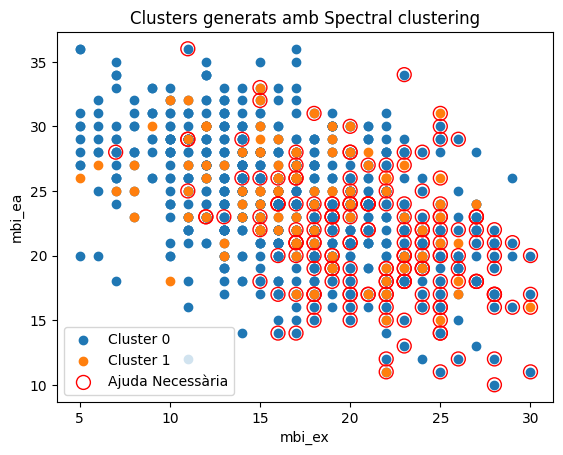

In [15]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_ea'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold['mbi_ex'], df_target_gt_threshold['mbi_ea'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Spectral clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

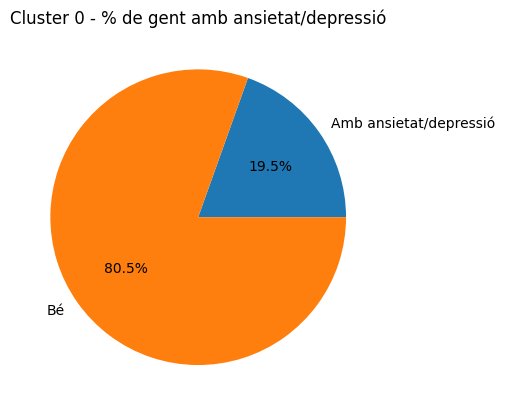

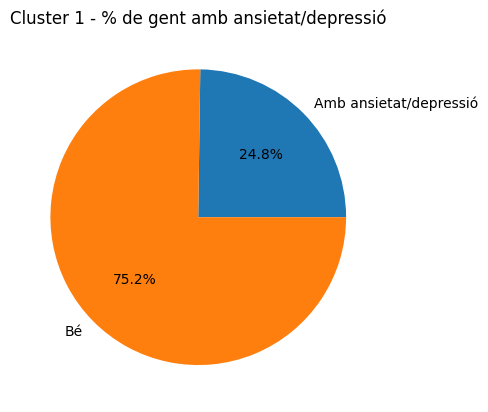

In [16]:
labels = 'Amb ansietat/depressió', 'Bé'
dades = []
for c in range(n_clusters):
    resta = total_cluster[c] - count_by_cluster[c]
    dades.append([count_by_cluster[c], resta])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

**Conclusions**

Considerant que el cluster 1 és el que hauria de tenir estudiants amb ansietat/depressió i veient els diagrames. Observem que el clúster 1 té un resultat bastant semblant de casos de depressió/ansietat al clúster 0. Llavors, com podem observar, podem assegurar que no estem obtenint una bona agrupació.

### Utilització de les característiques més rellevants

Fent 2 agrupacions per determinar si necessiten o no assistència médica

#### Random forest

Recordem que els coeficients amb Random Forest dels diferents atributs eren:

|    | atribut   | importancia |
|----|-----------|-------------|
| 9  | jspe      | 0.086444    |
| 10 | qcae_cog  | 0.084919    |
| 6  | stud_h    | 0.084754    |
| 11 | qcae_aff  | 0.082221    |
| 14 | mbi_ex    | 0.079569    |
| 12 | amsp      | 0.079371    |
| 13 | erec_mean | 0.078246    |
| 16 | mbi_ea    | 0.078138    |
| 15 | mbi_cy    | 0.073213    |
| 0  | age       | 0.067432    |
| 1  | year      | 0.048998    |
| 7  | health    | 0.041126    |
| 3  | glang     | 0.027404    |
| 4  | part      | 0.026077    |
| 5  | job       | 0.022708    |
| 2  | sex       | 0.021316    |
| 8  | psyt      | 0.018066    |

Per fer aquesta part ens quedarem els atributs que tenen l'importància major a **0.060000**

In [24]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

In [25]:
# X Random Forest
X_rf = X[['jspe', 'qcae_cog', 'stud_h', 'qcae_aff', 'mbi_ex', 'amsp', 'erec_mean', 'mbi_ea', 'mbi_cy', 'age']]

In [26]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

In [27]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X_rf)

In [28]:
df_clustered = X_rf.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,jspe,qcae_cog,stud_h,qcae_aff,mbi_ex,amsp,erec_mean,mbi_ea,mbi_cy,age,cluster
0,88,62,56,27,17,17,0.738095,20,13,18,1
1,109,55,20,37,14,22,0.690476,26,11,26,0
2,106,64,36,39,24,17,0.690476,23,7,21,1
3,101,52,51,33,16,18,0.833333,21,10,21,1
4,102,58,22,28,22,21,0.690476,23,14,21,0


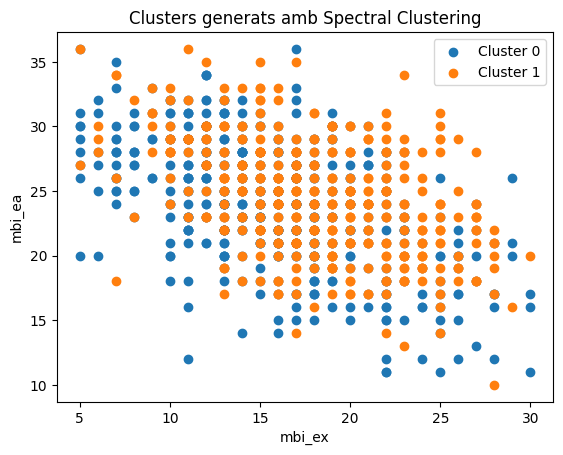

In [30]:
# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_ea'], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

In [31]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

               jspe   qcae_cog     stud_h   qcae_aff     mbi_ex       amsp  \
cluster                                                                      
0        107.852008  58.714588  12.871036  34.997886  15.873150  23.192389   
1        104.682809  58.309927  39.510896  34.539952  18.029056  23.101695   

         erec_mean     mbi_ea     mbi_cy        age  
cluster                                              
0          0.72536  24.023256  10.376321  23.302326  
1          0.71417  24.418886   9.738499  21.331719  


In [32]:
# Getting the number of patients in each cluster
total_cluster = cluster_grouped.size()
total_cluster

cluster
0    473
1    413
dtype: int64

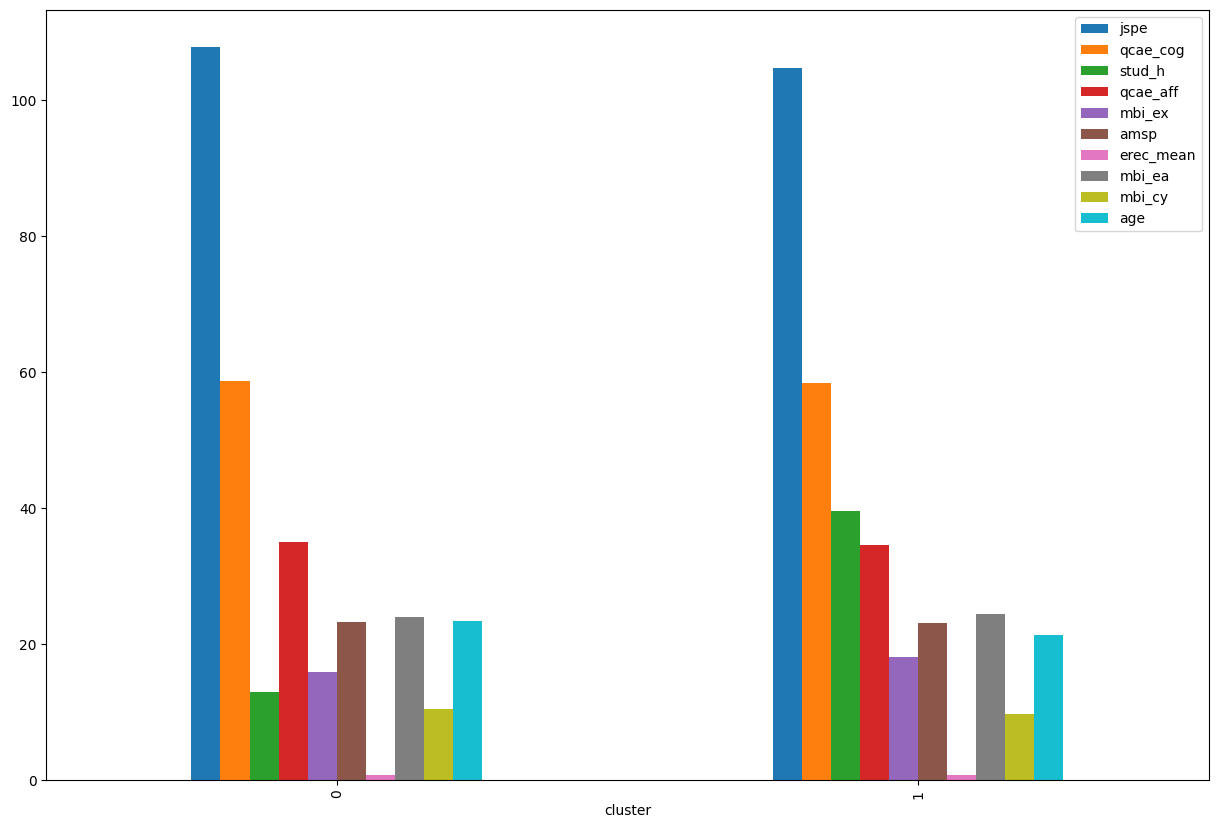

In [33]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

### Avaluació Model

In [34]:
cesd_max = 56
stai_t_max = 77
threshold = (cesd_max+stai_t_max)*0.6
threshold

79.8

In [35]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,jspe,qcae_cog,stud_h,qcae_aff,mbi_ex,amsp,erec_mean,mbi_ea,mbi_cy,age,cluster,target
0,88,62,56,27,17,17,0.738095,20,13,18,1,95
1,109,55,20,37,14,22,0.690476,26,11,26,0,40
2,106,64,36,39,24,17,0.690476,23,7,21,1,98
3,101,52,51,33,16,18,0.833333,21,10,21,1,65
4,102,58,22,28,22,21,0.690476,23,14,21,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...
881,106,63,45,39,23,28,0.619048,34,4,21,1,80
882,113,67,13,40,17,21,0.809524,24,5,20,0,67
883,100,50,50,31,15,24,0.547619,31,8,19,1,59
884,120,64,20,39,22,21,0.785714,19,15,24,0,91


In [36]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold = df_aval[df_aval['target'] > threshold]

# Fem el recompte agrupant per 'cluster'
count_by_cluster = df_target_gt_threshold.groupby('cluster').size()

# Mostrem el resultat
print("Recompte estudiants que necessiten ajuda\n", count_by_cluster)

print("\nRecompte estudiants totals en cluster\n", total_cluster)

Recompte estudiants que necessiten ajuda
 cluster
0     72
1    107
dtype: int64

Recompte estudiants totals en cluster
 cluster
0    473
1    413
dtype: int64


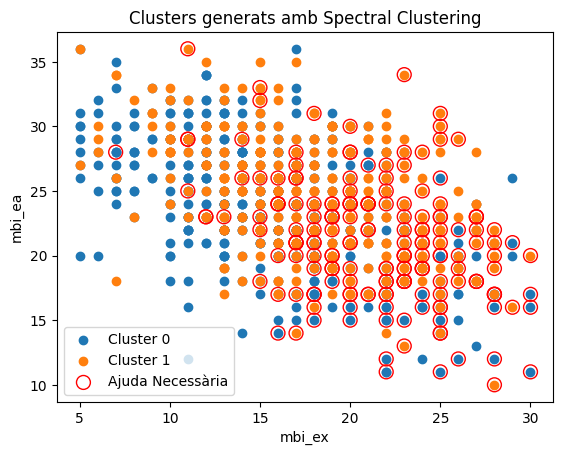

In [37]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_ea'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold['mbi_ex'], df_target_gt_threshold['mbi_ea'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

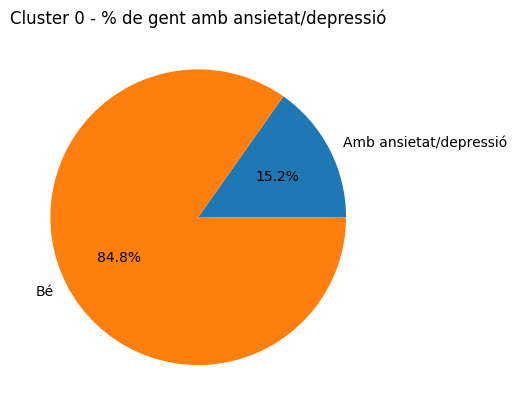

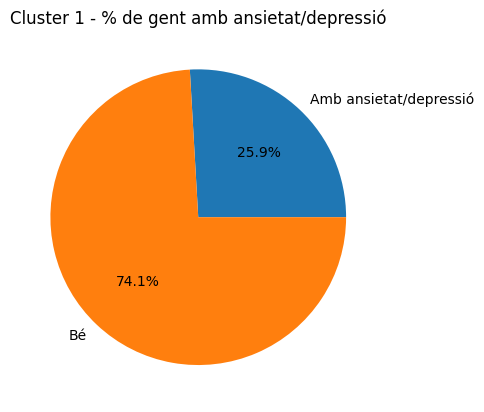

In [38]:
labels = 'Amb ansietat/depressió', 'Bé'
dades = []
for c in range(n_clusters):
    resta = total_cluster[c] - count_by_cluster[c]
    dades.append([count_by_cluster[c], resta])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

**Conclusions**

Quan hem utilitzat totes les característiques hem presuposat que el cluster 1 és el que hauria de tenir els estudiants amb necessitat d'ajuda psicològica. Recordem que teníem:
* Cluster 0: 19.5%
* Cluster 1: 24.8%

Ara un cop reduïdes les característiques gràcies a Random Forest, les agrupacions obtingudes tenen una mica més de diferència pel que fa el percentatge de gent amb ansietat/depressió:
* Cluster 0: 15.2%
* Cluster 1: 25.9%

Notem que reduint les característiques hem obtingut una millora pel que fa l'agrupació. Així, tornem a reduir el nombre de caracterísitques.

#### Random forest II

Recordem que els coeficients amb Random Forest dels atributs que hem tingut en compte abans:

|    | atribut   | importancia |
|----|-----------|-------------|
| 9  | jspe      | 0.086444    |
| 10 | qcae_cog  | 0.084919    |
| 6  | stud_h    | 0.084754    |
| 11 | qcae_aff  | 0.082221    |
| 14 | mbi_ex    | 0.079569    |
| 12 | amsp      | 0.079371    |
| 13 | erec_mean | 0.078246    |
| 16 | mbi_ea    | 0.078138    |
| 15 | mbi_cy    | 0.073213    |
| 0  | age       | 0.067432    |

Ara agafarem els atributs amb importància major a **0.080000**

In [1]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

In [2]:
# X Random Forest II
X_rf = X[['jspe', 'qcae_cog', 'stud_h', 'qcae_aff']]

In [4]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

In [5]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X_rf)

In [6]:
df_clustered = X_rf.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,jspe,qcae_cog,stud_h,qcae_aff,cluster
0,88,62,56,27,1
1,109,55,20,37,0
2,106,64,36,39,1
3,101,52,51,33,1
4,102,58,22,28,0


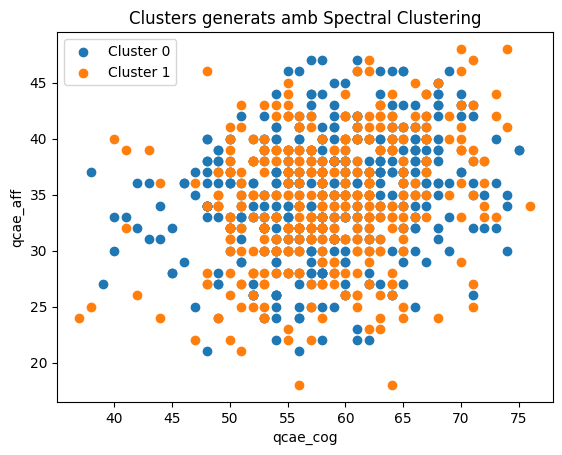

In [7]:
# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['qcae_cog'], cluster_points['qcae_aff'], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('qcae_cog')
plt.ylabel('qcae_aff')
plt.legend()
plt.show()

In [8]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

               jspe   qcae_cog     stud_h   qcae_aff
cluster                                             
0        107.567452  58.475375  12.698073  35.025696
1        105.045346  58.582339  39.322196  34.515513


In [9]:
# Getting the number of patients in each cluster
total_cluster = cluster_grouped.size()
total_cluster

cluster
0    467
1    419
dtype: int64

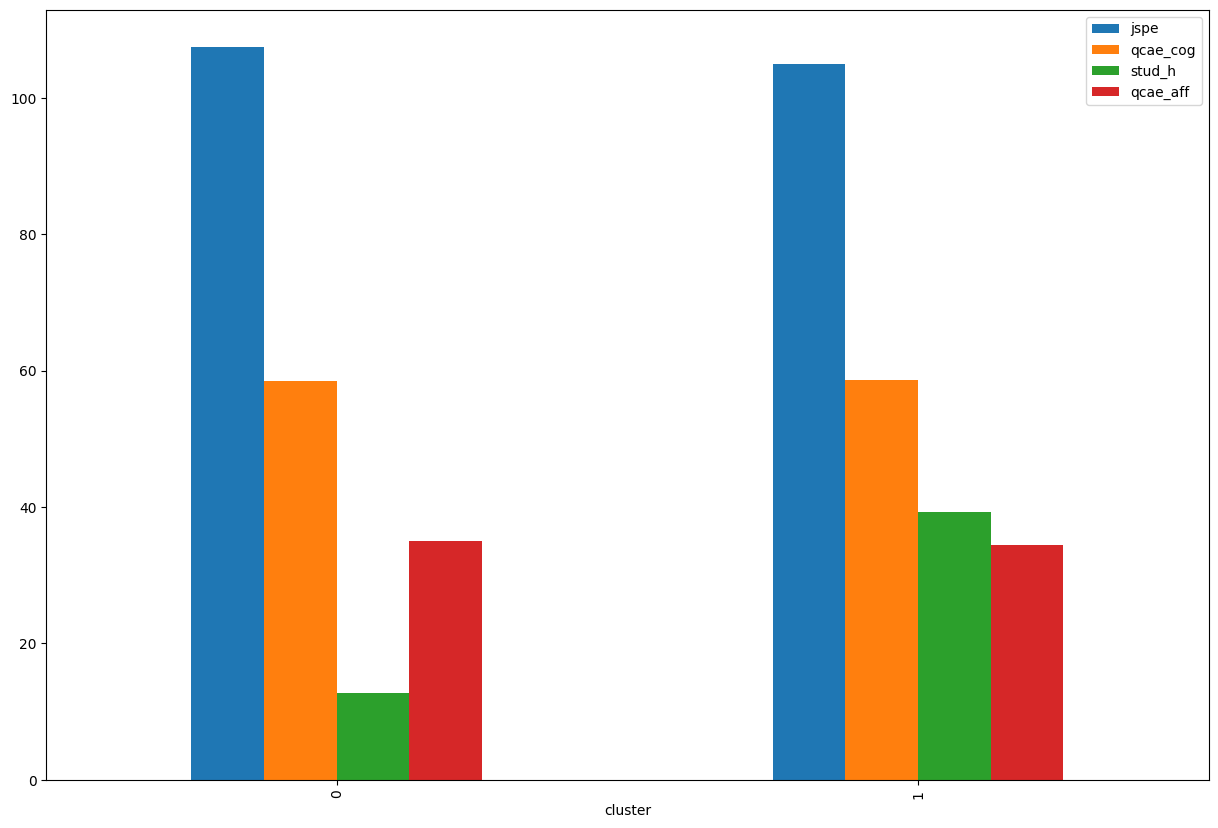

In [10]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

#### Avaluació Model

In [11]:
cesd_max = 56
stai_t_max = 77
threshold = (cesd_max+stai_t_max)*0.6
threshold

79.8

In [12]:
# fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,jspe,qcae_cog,stud_h,qcae_aff,cluster,target
0,88,62,56,27,1,95
1,109,55,20,37,0,40
2,106,64,36,39,1,98
3,101,52,51,33,1,65
4,102,58,22,28,0,60
...,...,...,...,...,...,...
881,106,63,45,39,1,80
882,113,67,13,40,0,67
883,100,50,50,31,1,59
884,120,64,20,39,0,91


In [13]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold = df_aval[df_aval['target'] > threshold]

# Fem el recompte agrupant per 'cluster'
count_by_cluster = df_target_gt_threshold.groupby('cluster').size()

# Mostrem el resultat
print("Recompte estudiants que necessiten ajuda\n", count_by_cluster)

print("\nRecompte estudiants totals en cluster\n", total_cluster)

Recompte estudiants que necessiten ajuda
 cluster
0     72
1    107
dtype: int64

Recompte estudiants totals en cluster
 cluster
0    467
1    419
dtype: int64


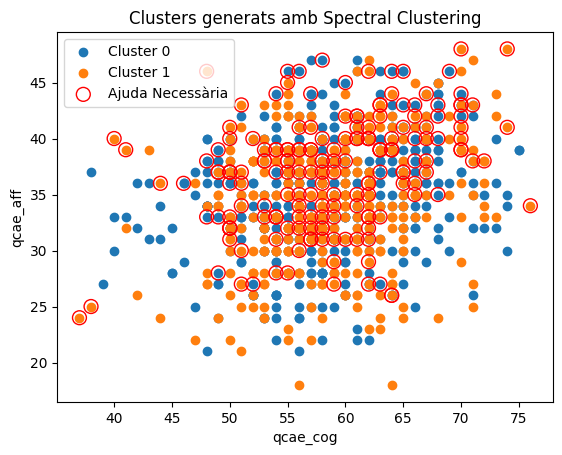

In [15]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['qcae_cog'], cluster_points['qcae_aff'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold['qcae_cog'], df_target_gt_threshold['qcae_aff'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('qcae_cog')
plt.ylabel('qcae_aff')
plt.legend()
plt.show()

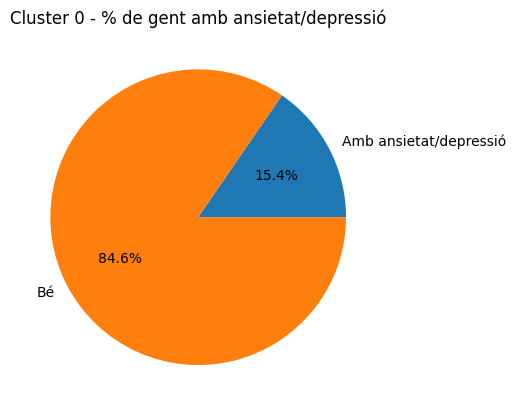

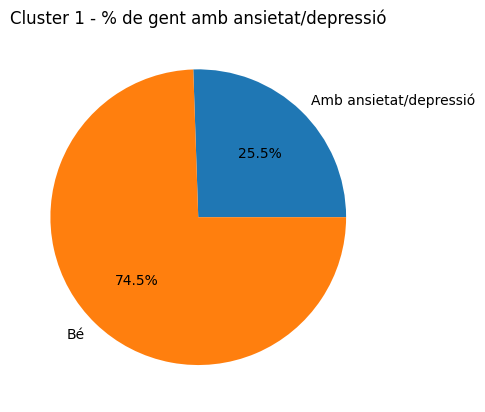

In [16]:
labels = 'Amb ansietat/depressió', 'Bé'
dades = []
for c in range(n_clusters):
    resta = total_cluster[c] - count_by_cluster[c]
    dades.append([count_by_cluster[c], resta])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

Quan hem reduït les característiques gràcies a Random Forest, els prcentatges de les agrupacions obtingudes eren:
* Cluster 0: 15.2%
* Cluster 1: 25.9%

Fent una altra reducció de característiques (fixant-nos amb la importància donada per Random Forest), obtenim:
* Cluster 0: 15.4%
* Cluster 1: 25.5%

Notem que no hem obtingut cap millora. Per tant, continuem provant altres mètodes per triar la rellevància de les característiques.

### Linear Regression

Ara en comptes de fer la reducció de característiques amb Random Forest, utilitzem els coeficients obtinguts després d'haver aplicat Linear Regression. 

Recordem que els coeficients amb Linear Regression dels diferents atributs eren:
|    | Feature   | Coefficient |
|----|-----------|-------------|
| 8  | psyt      | 7.979258    |
| 2  | sex       | 4.281193    |
| 13 | erec_mean | 2.110597    |
| 14 | mbi_ex    | 1.319494    |
| 11 | qcae_aff  | 0.742631    |
| 0  | age       | 0.380706    |
| 15 | mbi_cy    | 0.224846    |
| 6  | stud_h    | 0.124795    |
| 3  | glang     | 0.052498    |
| 10 | qcae_cog  | -0.039671   |
| 9  | jspe      | -0.168637   |
| 12 | amsp      | -0.382934   |
| 16 | mbi_ea    | -1.007413   |
| 1  | year      | -1.074211   |
| 5  | job       | -1.184904   |
| 4  | part      | -1.968074   |
| 7  | health    | -3.010553   |

Per fer aquesta part ens quedarem els atributs que tenen l'importància major a **0.100000**

In [17]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

In [18]:
# X Linear Regression
X_lr = X[['psyt', 'sex', 'erec_mean', 'mbi_ex', 'qcae_aff', 'age', 'mbi_cy', 'stud_h']]

In [21]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

In [22]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X_lr)

In [23]:
df_clustered = X_lr.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,psyt,sex,erec_mean,mbi_ex,qcae_aff,age,mbi_cy,stud_h,cluster
0,0,1,0.738095,17,27,18,13,56,0
1,0,1,0.690476,14,37,26,11,20,1
2,0,2,0.690476,24,39,21,7,36,0
3,0,2,0.833333,16,33,21,10,51,0
4,0,1,0.690476,22,28,21,14,22,1


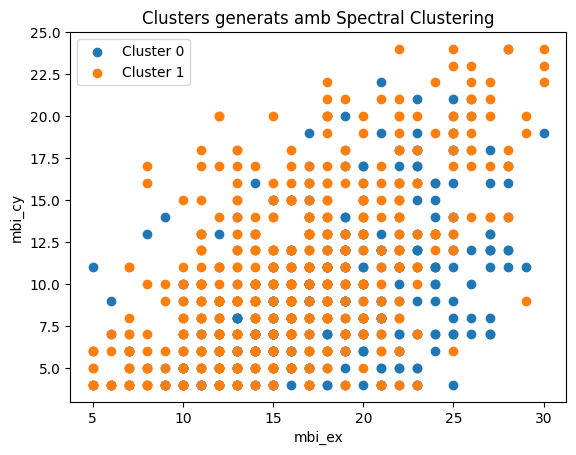

In [24]:

# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_cy'], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_cy')
plt.legend()
plt.show()

In [25]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

             psyt       sex  erec_mean     mbi_ex  qcae_aff        age  \
cluster                                                                  
0        0.204663  1.699482   0.714162  17.909326  34.61658  21.352332   
1        0.240000  1.692000   0.724762  16.082000  34.91400  23.180000   

            mbi_cy     stud_h  
cluster                        
0         9.541451  40.448187  
1        10.494000  13.586000  


In [26]:
# Getting the number of patients in each cluster
total_cluster = cluster_grouped.size()
total_cluster

cluster
0    386
1    500
dtype: int64

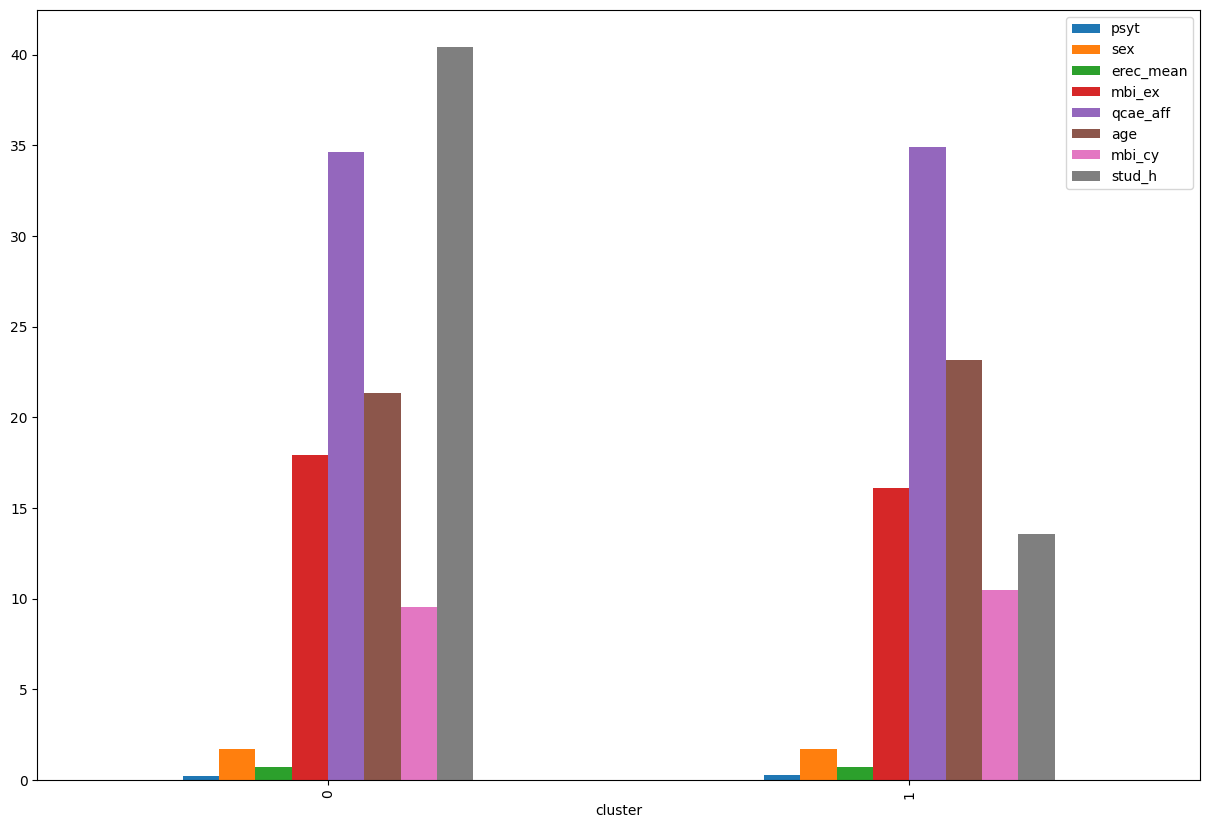

In [27]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

#### Avaluació Model

In [28]:
cesd_max = 56
stai_t_max = 77
threshold = (cesd_max+stai_t_max)*0.6
threshold

79.8

In [29]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,psyt,sex,erec_mean,mbi_ex,qcae_aff,age,mbi_cy,stud_h,cluster,target
0,0,1,0.738095,17,27,18,13,56,0,95
1,0,1,0.690476,14,37,26,11,20,1,40
2,0,2,0.690476,24,39,21,7,36,0,98
3,0,2,0.833333,16,33,21,10,51,0,65
4,0,1,0.690476,22,28,21,14,22,1,60
...,...,...,...,...,...,...,...,...,...,...
881,0,1,0.619048,23,39,21,4,45,0,80
882,0,2,0.809524,17,40,20,5,13,1,67
883,0,1,0.547619,15,31,19,8,50,0,59
884,1,2,0.785714,22,39,24,15,20,1,91


In [30]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold = df_aval[df_aval['target'] > threshold]

# Fem el recompte agrupant per 'cluster'
count_by_cluster = df_target_gt_threshold.groupby('cluster').size()

# Mostrem el resultat
print("Recompte estudiants que necessiten ajuda\n", count_by_cluster)

print("\nRecompte estudiants totals en cluster\n", total_cluster)

Recompte estudiants que necessiten ajuda
 cluster
0    98
1    81
dtype: int64

Recompte estudiants totals en cluster
 cluster
0    386
1    500
dtype: int64


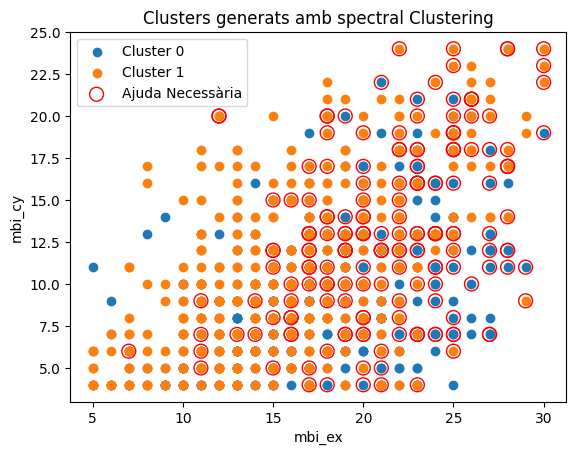

In [31]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_cy'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold['mbi_ex'], df_target_gt_threshold['mbi_cy'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_cy')
plt.legend()
plt.show()

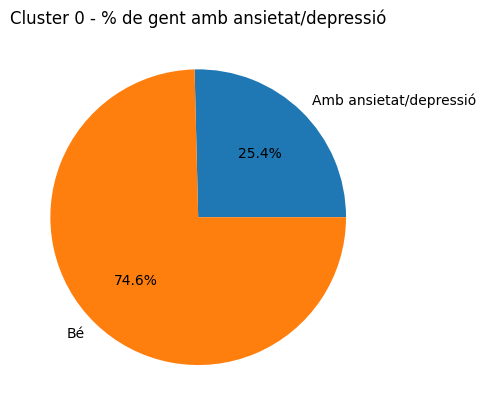

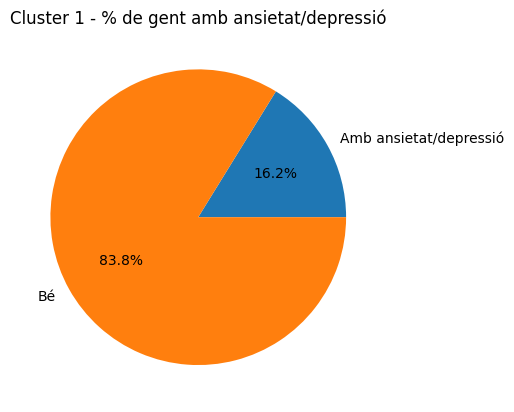

In [32]:
labels = 'Amb ansietat/depressió', 'Bé'
dades = []
for c in range(n_clusters):
    resta = total_cluster[c] - count_by_cluster[c]
    dades.append([count_by_cluster[c], resta])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

**Conclusions**

Quan hem reduït les característiques segons els coeficients de Random Forest, les agrupacions obtingudes tenien  el percentatge de gent amb ansietat/depressió:
* Cluster 0: 15.2%
* Cluster 1: 25.9%

Ara que hem tret certes característiques seguint els coeficients de la Regressió lineal, tenim:
* Cluster 0: 25.4%
* Cluster 1: 16.2%

Podem dir que no tenim una gran millora, és cert que el cluster 0 (abans 1) és el cluster que té més estudiants amb ansietat o depressió, però dosminueix una mica la proporció: de 25.9% a 25.4%

Com no veiem cap tendència de millora del nostre model, procedirem a tenir en compte menys característiques (amb el cirteri dels coeficients de Linear Regression).

#### Linear Regression II

Recordem que els coeficients amb Linear Regression dels atributs que hem tingut en compte abans:

|    | Feature   | Coefficient |
|----|-----------|-------------|
| 8  | psyt      | 7.979258    |
| 2  | sex       | 4.281193    |
| 13 | erec_mean | 2.110597    |
| 14 | mbi_ex    | 1.319494    |
| 11 | qcae_aff  | 0.742631    |
| 0  | age       | 0.380706    |
| 15 | mbi_cy    | 0.224846    |
| 6  | stud_h    | 0.124795    |

Ara ens quedarem els atributs que tenen l'importància major a **1.000000**

In [33]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

In [34]:
# X Linear Regression
X_lr = X[['psyt', 'sex', 'erec_mean', 'mbi_ex']]

In [35]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

In [36]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X_lr)

c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [37]:
df_clustered = X_lr.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,psyt,sex,erec_mean,mbi_ex,cluster
0,0,1,0.738095,17,0
1,0,1,0.690476,14,1
2,0,2,0.690476,24,0
3,0,2,0.833333,16,1
4,0,1,0.690476,22,0


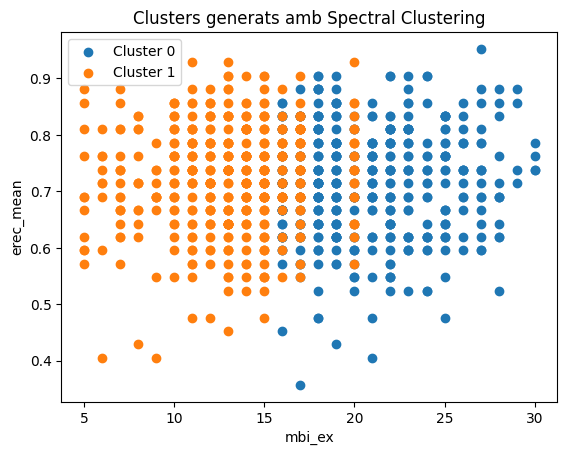

In [38]:
# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['erec_mean'], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('erec_mean')
plt.legend()
plt.show()

In [39]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

             psyt       sex  erec_mean     mbi_ex
cluster                                          
0        0.330254  1.681293    0.71566  20.935335
1        0.123620  1.708609    0.72443  13.000000


In [40]:
# Getting the number of patients in each cluster
total_cluster = cluster_grouped.size()
total_cluster

cluster
0    433
1    453
dtype: int64

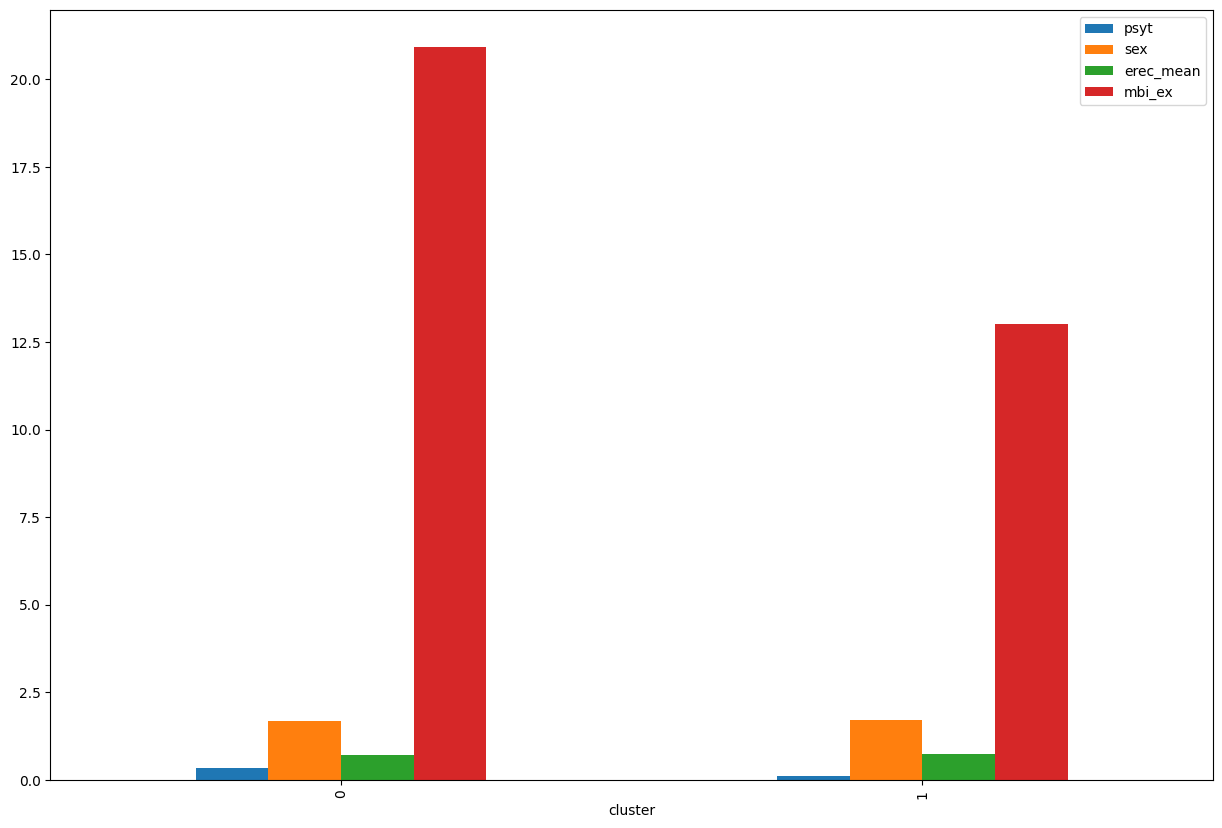

In [41]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

In [42]:
cesd_max = 56
stai_t_max = 77
threshold = (cesd_max+stai_t_max)*0.6
threshold

79.8

In [43]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,psyt,sex,erec_mean,mbi_ex,cluster,target
0,0,1,0.738095,17,0,95
1,0,1,0.690476,14,1,40
2,0,2,0.690476,24,0,98
3,0,2,0.833333,16,1,65
4,0,1,0.690476,22,0,60
...,...,...,...,...,...,...
881,0,1,0.619048,23,0,80
882,0,2,0.809524,17,1,67
883,0,1,0.547619,15,1,59
884,1,2,0.785714,22,0,91


In [44]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold = df_aval[df_aval['target'] > threshold]

# Fem el recompte agrupant per 'cluster'
count_by_cluster = df_target_gt_threshold.groupby('cluster').size()

# Mostrem el resultat
print("Recompte estudiants que necessiten ajuda\n", count_by_cluster)

print("\nRecompte estudiants totals en cluster\n", total_cluster)

Recompte estudiants que necessiten ajuda
 cluster
0    150
1     29
dtype: int64

Recompte estudiants totals en cluster
 cluster
0    433
1    453
dtype: int64


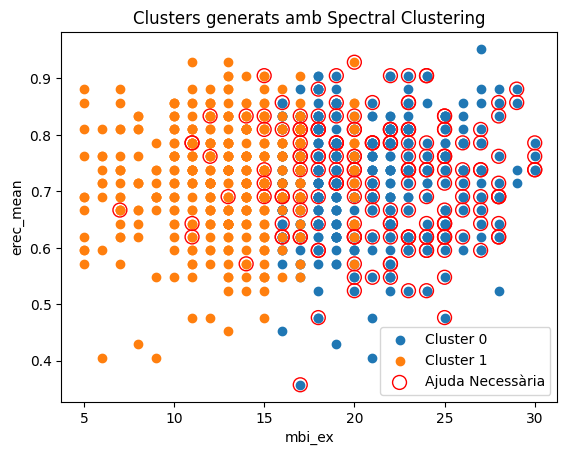

In [46]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['erec_mean'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold['mbi_ex'], df_target_gt_threshold['erec_mean'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('erec_mean')
plt.legend()
plt.show()

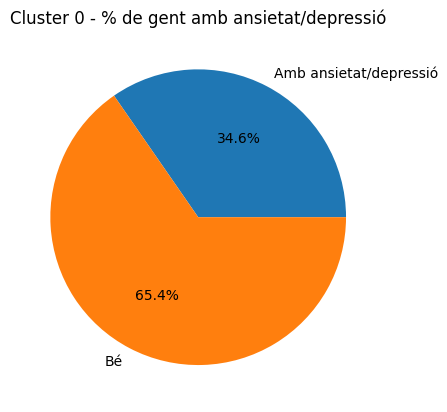

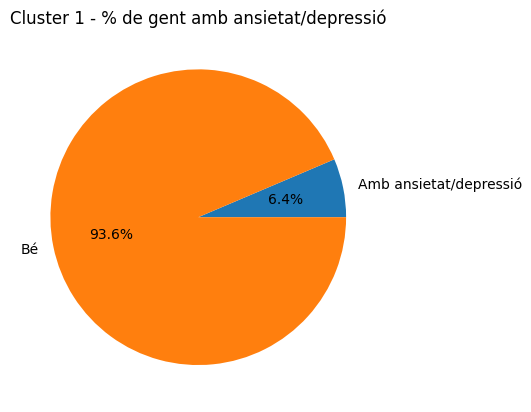

In [47]:
labels = 'Amb ansietat/depressió', 'Bé'
dades = []
for c in range(n_clusters):
    resta = total_cluster[c] - count_by_cluster[c]
    dades.append([count_by_cluster[c], resta])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

**Conclusions**

Quan hem reduït les característiques seguint els coeficients de la Regressió lineal, quedant-nos aquelles que són superiors a 0.1, teniem:
* Cluster 0: 25.4%
* Cluster 1: 16.2%

I amb el mateix procés, però amb les característiques amb coeficients majors a 1 obtenim:
* Cluster 0: 34.6%
* Cluster 1: 6.4%

Podem observar bastanta millora. Però com ja hem redüit les característiques molts cops, ara en comptes de seguir reduïnt mirarem a veure que passa si clusteritzem amb més grups.

### Utilització de les característiques rellevants

Com a característiques rellevants fem servir aquelles que tenen coeficient major a **1.000000**

|    | Feature   | Coefficient |
|----|-----------|-------------|
| 8  | psyt      | 7.979258    |
| 2  | sex       | 4.281193    |
| 13 | erec_mean | 2.110597    |
| 14 | mbi_ex    | 1.319494    |


Fent 3 agrupacions per determinar si:
* necessiten assitència mèdica
* recomanable tenir assitència mèdica
* no necessiten assitència mèdica  

In [22]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

In [23]:
# X Linear Regression
X_lr = X[['psyt', 'sex', 'erec_mean', 'mbi_ex']]

In [24]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

In [25]:
n_clusters = 3  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X_lr)

c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [26]:
df_clustered = X_lr.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,psyt,sex,erec_mean,mbi_ex,cluster
0,0,1,0.738095,17,2
1,0,1,0.690476,14,0
2,0,2,0.690476,24,1
3,0,2,0.833333,16,0
4,0,1,0.690476,22,1


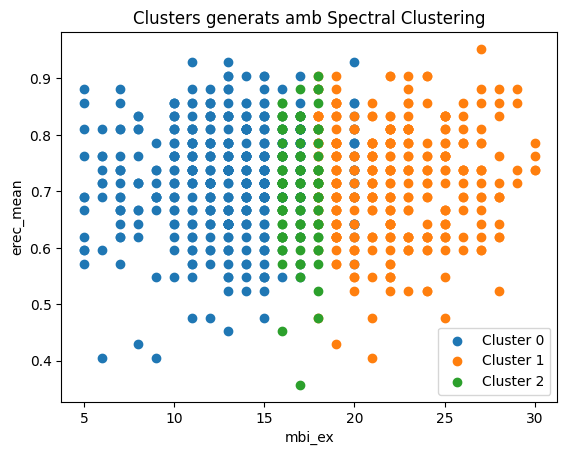

In [27]:
# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['erec_mean'], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('erec_mean')
plt.legend()
plt.show()

In [28]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

             psyt       sex  erec_mean     mbi_ex
cluster                                          
0        0.123620  1.708609   0.724430  13.000000
1        0.287462  1.773700   0.718873  22.238532
2        0.462264  1.396226   0.705750  16.915094


In [29]:
# Getting the number of patients in each cluster
total_cluster = cluster_grouped.size()
total_cluster

cluster
0    453
1    327
2    106
dtype: int64

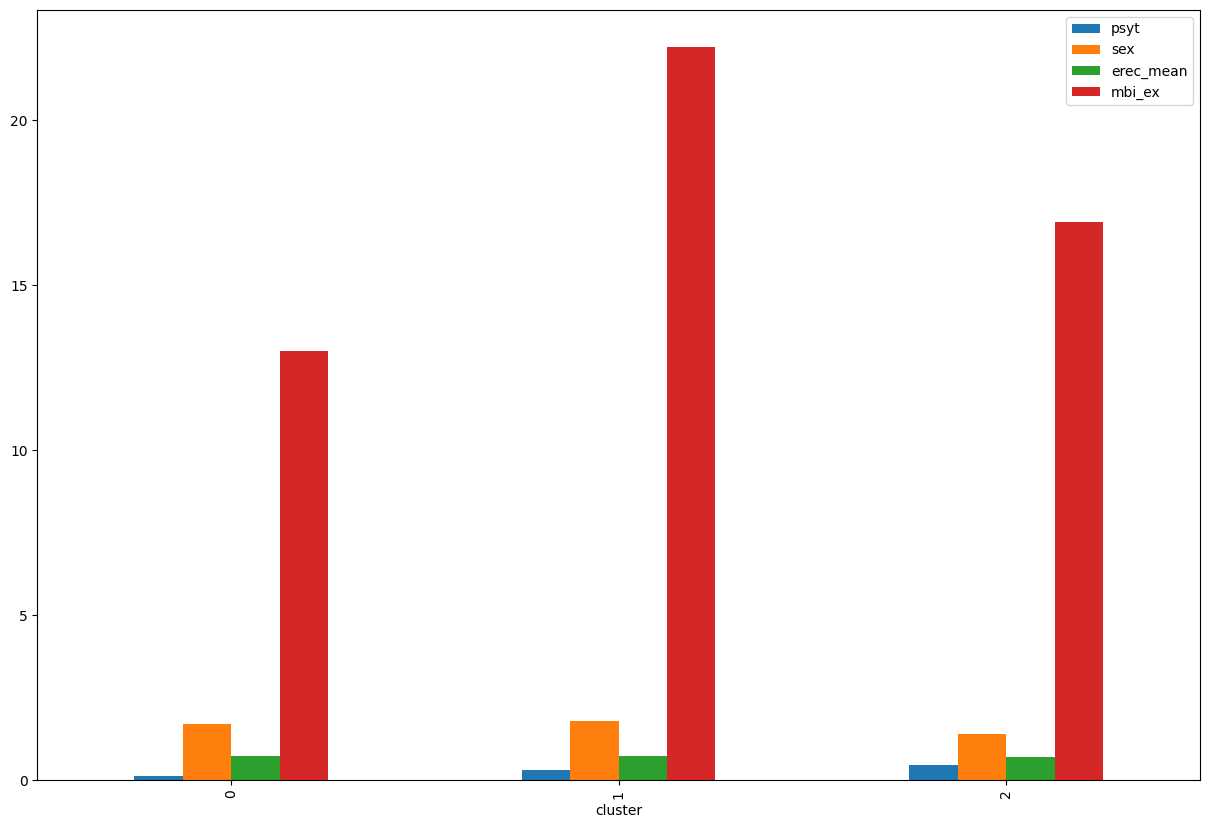

In [30]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

#### Avaluació Model

In [31]:
cesd_max = 56
stai_t_max = 77
threshold1 = (cesd_max+stai_t_max)*0.33
print("threshold1", threshold1)
threshold2 = (cesd_max+stai_t_max)*0.66
print("threshold2", threshold2)

threshold1 43.89
threshold2 87.78


In [32]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,psyt,sex,erec_mean,mbi_ex,cluster,target
0,0,1,0.738095,17,2,95
1,0,1,0.690476,14,0,40
2,0,2,0.690476,24,1,98
3,0,2,0.833333,16,0,65
4,0,1,0.690476,22,1,60
...,...,...,...,...,...,...
881,0,1,0.619048,23,1,80
882,0,2,0.809524,17,0,67
883,0,1,0.547619,15,0,59
884,1,2,0.785714,22,1,91


In [33]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold1 = df_aval[df_aval['target'] < threshold1]
df_target_gt_threshold2 = df_aval[(df_aval['target'] > threshold1) & (df_aval['target'] < threshold2)]
df_target_gt_threshold3 = df_aval[df_aval['target'] > threshold2]

# Fem el recompte agrupant per 'cluster'
count_by_cluster1 = df_target_gt_threshold1.groupby('cluster').size()
count_by_cluster2 = df_target_gt_threshold2.groupby('cluster').size()
count_by_cluster3 = df_target_gt_threshold3.groupby('cluster').size()

# Mostrem els resultats
print("Recompte estudiants que NO necessiten ajuda\n", count_by_cluster1)
print("\nRecompte estudiants recomanable rebre ajuda\n", count_by_cluster2)
print("\nRecompte estudiants que SÍ necessiten ajuda\n", count_by_cluster3)

print("\nRecompte estudiants totals en cluster\n", total_cluster)

Recompte estudiants que NO necessiten ajuda
 cluster
0    171
1     22
2     16
dtype: int64

Recompte estudiants recomanable rebre ajuda
 cluster
0    270
1    217
2     78
dtype: int64

Recompte estudiants que SÍ necessiten ajuda
 cluster
0    12
1    88
2    12
dtype: int64

Recompte estudiants totals en cluster
 cluster
0    453
1    327
2    106
dtype: int64


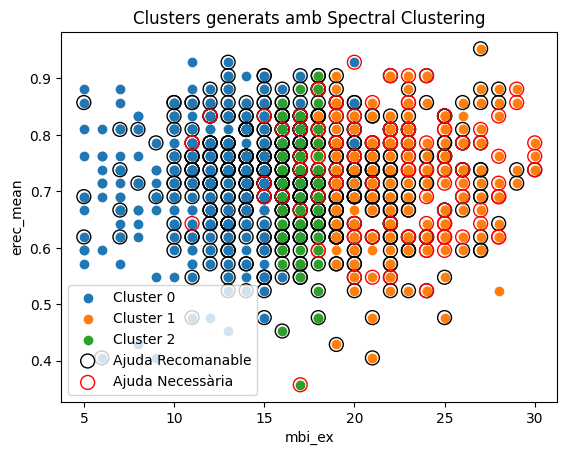

In [34]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['erec_mean'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold2['mbi_ex'], df_target_gt_threshold2['erec_mean'], label='Ajuda Recomanable', facecolors='none', edgecolors='black', marker='o', s=100)
plt.scatter(df_target_gt_threshold3['mbi_ex'], df_target_gt_threshold3['erec_mean'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('erec_mean')
plt.legend()
plt.show()

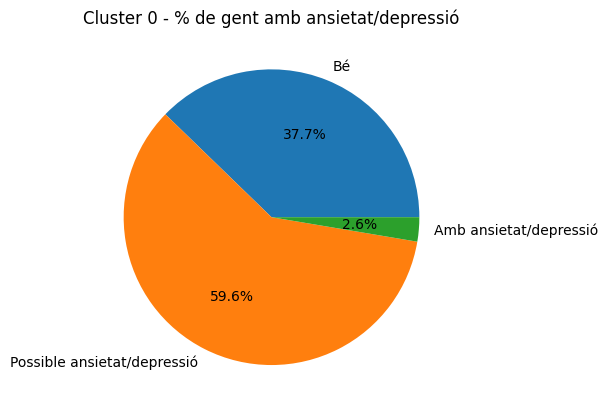

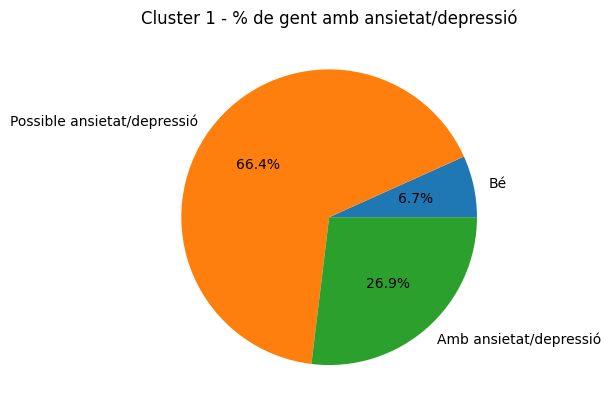

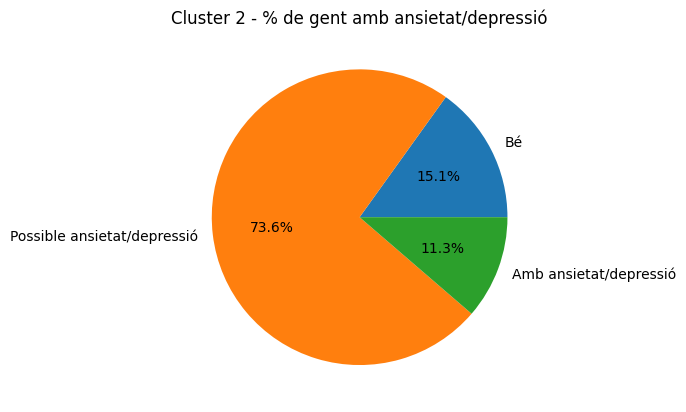

In [35]:
labels = 'Bé', 'Possible ansietat/depressió', 'Amb ansietat/depressió'
dades = []
for c in range(n_clusters):
    dades.append([count_by_cluster1[c], count_by_cluster2[c], count_by_cluster3[c]])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

**Conclusions**

Recordem que quan hem treballat amb dos clusters i amb les característiques amb els coeficients calculats amb Linear Regression:
* Cluster 0: 34.6%
* Cluster 1: 6.4%

Ara treballant amb 3 clusters:

|  Cluster  | bé   | possible depressió/ansietat | depressió/ansietat |
|----|-----------| ---------------|-------------|
| 0  | 37.7%  | 59.6% | 2.6%    | 
| 1  |6.7%      | 66.4% | 26.9%    |
| 2  | 15.1%    | 73.6% | 11.3%    |

Veient aquests resultats podem, no amb gaire certesa, dir que el clúster 1 té tendència a tenir depressió o ansietat. Mentre que el cluster 0 sembla que tingui més proporció d'estudiants amb persones sanes, psicològicament.


Ara veurem que passa si canviem el thresholds.

#### Canvi thresholds

In [36]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

In [37]:
# X Linear Regression
X_lr = X[['psyt', 'sex', 'erec_mean', 'mbi_ex']]

In [38]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

In [39]:
n_clusters = 3  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X_lr)

c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [40]:
df_clustered = X_lr.copy() 
df_clustered['cluster'] = clusters 

In [41]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

total_cluster = cluster_grouped.size()

             psyt       sex  erec_mean     mbi_ex
cluster                                          
0        0.123620  1.708609   0.724430  13.000000
1        0.287462  1.773700   0.718873  22.238532
2        0.462264  1.396226   0.705750  16.915094


In [42]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,psyt,sex,erec_mean,mbi_ex,cluster,target
0,0,1,0.738095,17,2,95
1,0,1,0.690476,14,0,40
2,0,2,0.690476,24,1,98
3,0,2,0.833333,16,0,65
4,0,1,0.690476,22,1,60
...,...,...,...,...,...,...
881,0,1,0.619048,23,1,80
882,0,2,0.809524,17,0,67
883,0,1,0.547619,15,0,59
884,1,2,0.785714,22,1,91


In [43]:
cesd_max = 56
stai_t_max = 77
threshold1 = (cesd_max+stai_t_max)*0.55
print("threshold1", threshold1)
threshold2 = (cesd_max+stai_t_max)*0.85
print("threshold2", threshold2)

threshold1 73.15
threshold2 113.05


In [44]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold1 = df_aval[df_aval['target'] < threshold1]
df_target_gt_threshold2 = df_aval[(df_aval['target'] > threshold1) & (df_aval['target'] < threshold2)]
df_target_gt_threshold3 = df_aval[df_aval['target'] > threshold2]

# Fem el recompte agrupant per 'cluster'
count_by_cluster1 = df_target_gt_threshold1.groupby('cluster').size()
count_by_cluster2 = df_target_gt_threshold2.groupby('cluster').size()
count_by_cluster3 = df_target_gt_threshold3.groupby('cluster').size()

# Mostrem els resultats
print("Recompte estudiants que NO necessiten ajuda\n", count_by_cluster1)
print("\nRecompte estudiants recomanable rebre ajuda\n", count_by_cluster2)
print("\nRecompte estudiants que SÍ necessiten ajuda\n", count_by_cluster3)

print("\nRecompte estudiants totals en cluster\n", total_cluster)

Recompte estudiants que NO necessiten ajuda
 cluster
0    411
1    166
2     75
dtype: int64

Recompte estudiants recomanable rebre ajuda
 cluster
0     42
1    150
2     30
dtype: int64

Recompte estudiants que SÍ necessiten ajuda
 cluster
1    11
2     1
dtype: int64

Recompte estudiants totals en cluster
 cluster
0    453
1    327
2    106
dtype: int64


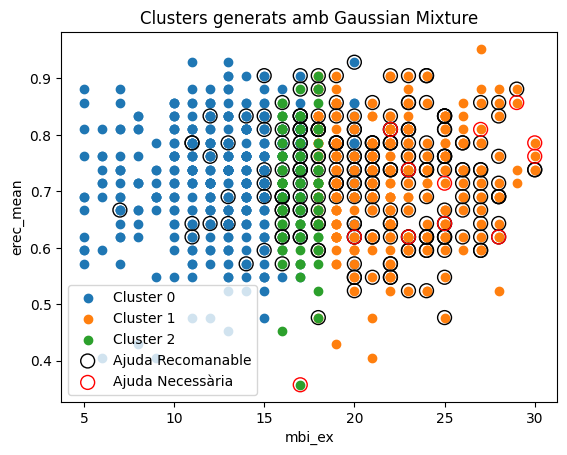

In [45]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['erec_mean'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold2['mbi_ex'], df_target_gt_threshold2['erec_mean'], label='Ajuda Recomanable', facecolors='none', edgecolors='black', marker='o', s=100)
plt.scatter(df_target_gt_threshold3['mbi_ex'], df_target_gt_threshold3['erec_mean'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Gaussian Mixture')
plt.xlabel('mbi_ex')
plt.ylabel('erec_mean')
plt.legend()
plt.show()

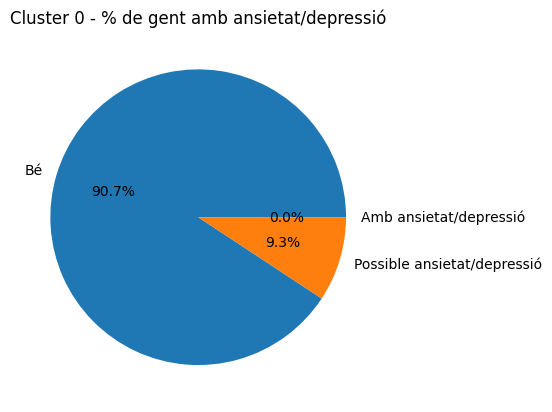

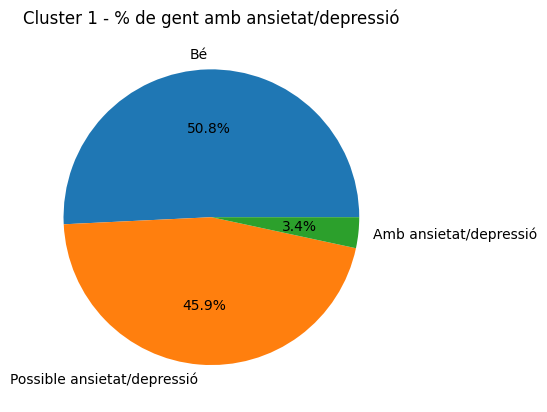

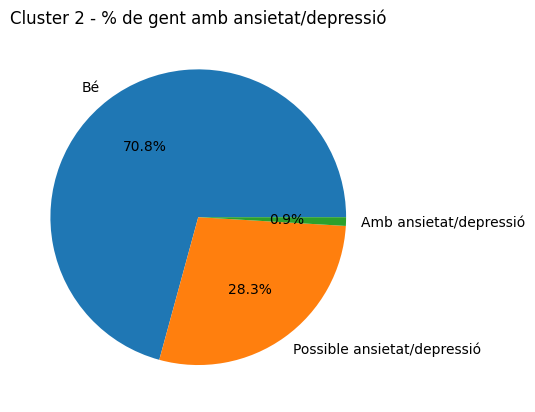

In [51]:
import matplotlib.pyplot as plt

labels = 'Bé', 'Possible ansietat/depressió', 'Amb ansietat/depressió'
dades = []

for c in range(n_clusters):
    count1 = count_by_cluster1.get(c, 0)
    count2 = count_by_cluster2.get(c, 0)
    count3 = count_by_cluster3.get(c, 0)
    dades.append([count1, count2, count3])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()


**Conclusions**

Abans treballant amb
* threshold1 = 43.89 
* threshold2 = 87.78

|  Cluster  | bé   | possible depressió/ansietat | depressió/ansietat |
|----|-----------| ---------------|-------------|
| 0  | 37.7%  | 59.6% | 2.6%    | 
| 1  |6.7%      | 66.4% | 26.9%    |
| 2  | 15.1%    | 73.6% | 11.3%    |

Ara amb:
* threshold1 = 73.15 
* threshold2 113.05

|  Cluster  | bé  | possible depressió/ansietat | depressió/ansietat  |
|----|-----------| ---------------|-------------|
| 0  | 90.7%  | 9.3% | 0.0%    |
| 1  | 50.8%   | 45.9% | 3.4%    |
| 2  | 70.8%      | 28.3% | 0.9%    |


Veient aquests últims resultats podem afirmar que el cluster 0 té més proporció d'estudiants amb persones sanes, psicològicament. I que el clúster 1 té més tendència que els altres a tenir depressió o ansietat.
